## Author: **Dai-Phuong Ngo (Liam)**

## Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libraries

In [3]:
import pandas as pd
import numpy as np
import re
import warnings
import matplotlib
import matplotlib.pyplot as plt
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import os

In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
import nltk
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [6]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import warnings
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

## Data Exploration

### Load Transcription Data

In [7]:
import pandas as pd

# Custom trim function
def trim(df):
    df.columns = df.columns.str.strip()
    df = df.drop_duplicates()
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ', '_')
    df_obj = df.select_dtypes(['object'])
    df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
    print("All column names have been stripped, lowercased, and spaces replaced with underscores.")
    print("Dropped duplicate rows if any.")
    print("Categorical values have been stripped.")
    return df

# Set display options
pd.set_option('display.max_colwidth', 255)

# Load data from the specified Google Drive path
file_path = '/content/drive/My Drive/Colab Notebooks/Harvard/CSCI E-192 Modern Data Analytics/Data/mtsamples.csv'
df = pd.read_csv(file_path)

# Drop unnecessary column
df.drop('Unnamed: 0', axis=1, inplace=True)

# Apply trim function
df = trim(df)

# Value count function
def vc(df, column, r=False):
    vc_df = df.reset_index().groupby([column]).size().to_frame('count')
    vc_df['percentage (%)'] = vc_df['count'].div(sum(vc_df['count'])).mul(100)
    vc_df = vc_df.sort_values(by=['percentage (%)'], ascending=False)
    if r:
        return vc_df
    else:
        print(f'STATUS: Value counts of "{column}"...')
        display(vc_df)

# Shape function
def shape(df, df_name):
    print(f'STATUS: Dimension of "{df_name}" = {df.shape}')

# Preview first 3 rows
df.head(3)


All column names have been stripped, lowercased, and spaces replaced with underscores.
Dropped duplicate rows if any.
Categorical values have been stripped.


,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with complaint of allergies.,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female presents with complaint of allergies. She used to have allergies when she lived in Seattle but she thinks they are worse here. In the past, she has tried Claritin, and Zyrtec. Both worked for short time b...","allergy / immunology, allergic rhinitis, allergies, asthma, nasal sprays, rhinitis, nasal, erythematous, allegra, sprays, allergic,"
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climbing stairs, difficulty with airline seats, tying shoes, used to public seating, and lifting objects off the floor. He exercises three times a week at home and does cardio. He has difficulty walking two b...","bariatrics, laparoscopic gastric bypass, weight loss programs, gastric bypass, atkin's diet, weight watcher's, body weight, laparoscopic gastric, weight loss, pounds, months, weight, laparoscopic, band, loss, diets, overweight, lost"
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC today. He is a very pleasant gentleman who is 42 years old, 344 pounds. He is 5'9"". He has a BMI of 51. He has been overweight for ten years since the age of 33, at his highest he was 358 pounds, at hi...","bariatrics, laparoscopic gastric bypass, heart attacks, body weight, pulmonary embolism, potential complications, sleep study, weight loss, gastric bypass, anastomosis, loss, sleep, laparoscopic, gastric, bypass, heart, pounds, weight,"


In [8]:
df.shape

(4999, 5)

In [9]:
df['medical_specialty'].unique()

array(['Allergy / Immunology', 'Bariatrics', 'Cardiovascular / Pulmonary',
       'Neurology', 'Dentistry', 'Urology', 'General Medicine', 'Surgery',
       'Speech - Language', 'SOAP / Chart / Progress Notes',
       'Sleep Medicine', 'Rheumatology', 'Radiology',
       'Psychiatry / Psychology', 'Podiatry', 'Physical Medicine - Rehab',
       'Pediatrics - Neonatal', 'Pain Management', 'Orthopedic',
       'Ophthalmology', 'Office Notes', 'Obstetrics / Gynecology',
       'Neurosurgery', 'Nephrology', 'Letters',
       'Lab Medicine - Pathology', 'IME-QME-Work Comp etc.',
       'Hospice - Palliative Care', 'Hematology - Oncology',
       'Gastroenterology', 'ENT - Otolaryngology', 'Endocrinology',
       'Emergency Room Reports', 'Discharge Summary',
       'Diets and Nutritions', 'Dermatology',
       'Cosmetic / Plastic Surgery', 'Consult - History and Phy.',
       'Chiropractic', 'Autopsy'], dtype=object)

### Filter

In [10]:
df = df[df['medical_specialty'].isin(['Neurosurgery','ENT - Otolaryngology','Discharge Summary'])]
shape(df,'df')

STATUS: Dimension of "df" = (300, 5)


In [11]:
# df = df[df['medical_specialty'].isin(['Neurology','Radiology','Urology'])]
# shape(df,'df')

### Word Counts of Each Medical Specialty

In [12]:
medical_specialty_list = [] ; word_count_list =[]
for medical_specialty in df['medical_specialty'].unique():
    df_filter = df.loc[(df['medical_specialty'] == medical_specialty)]
    word_count_temp = df_filter['transcription'].str.split().str.len().sum()
    medical_specialty_list.append(medical_specialty)
    word_count_list.append(word_count_temp)
word_count_df = pd.DataFrame({'Medical Specialty':medical_specialty_list, 'Word Count':word_count_list})
word_count_df['Word Count'] = word_count_df['Word Count'].astype('int')
word_count_df = word_count_df.sort_values('Word Count', ascending=False)
word_count_df.reset_index(drop=True)

,Medical Specialty,Word Count
0,Neurosurgery,54233
1,Discharge Summary,43103
2,ENT - Otolaryngology,42032


In [13]:
total_word_count = df['transcription'].str.split().str.len().sum()
print(f'The word count of all transcription is: {int(total_word_count)}')

The word count of all transcription is: 139368


### Sample Size of Each Medical Specialty

In [14]:
vc(df, 'medical_specialty')

STATUS: Value counts of "medical_specialty"...


,count,percentage (%)
medical_specialty,,
Discharge Summary,108,36.000000
ENT - Otolaryngology,98,32.666667
Neurosurgery,94,31.333333


### Data Cleansing

In [15]:
print(f'data shape is: {df.shape}')

# to identify the null values by descending order
df.isnull().sum().sort_values(ascending = False)

data shape is: (300, 5)


,0
keywords,56
transcription,2
description,0
sample_name,0
medical_specialty,0


In [16]:
df = df[df['transcription'].notna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 298 entries, 2656 to 3994
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        298 non-null    object
 1   medical_specialty  298 non-null    object
 2   sample_name        298 non-null    object
 3   transcription      298 non-null    object
 4   keywords           242 non-null    object
dtypes: object(5)
memory usage: 14.0+ KB


In [17]:
df =df.drop(['description','sample_name','keywords'], axis=1)
df.head(2)

,medical_specialty,transcription
2656,Neurosurgery,"TITLE OF OPERATION:, A complex closure and debridement of wound.,INDICATION FOR SURGERY:, The patient is a 26-year-old female with a long history of shunt and hydrocephalus presenting with a draining wound in the right upper quadrant, just below the..."
2657,Neurosurgery,"TITLE OF OPERATION: , Placement of right new ventriculoperitoneal (VP) shunts Strata valve and to removal of right frontal Ommaya reservoir.,INDICATION FOR SURGERY: , The patient is a 2-month-old infant, born premature with intraventricular hemorrhage..."


## Text Normalization

- Lower Case

- Remove punctuation and numbers

- Tokenisation of the transcription

- Lemmatization

- Remove Stop Words

In [18]:
def lower(df, attribute):
    df.loc[:,attribute] = df[attribute].apply(lambda x : str.lower(x))
    return df
df = lower(df,'transcription')
df.head(3)

,medical_specialty,transcription
2656,Neurosurgery,"title of operation:, a complex closure and debridement of wound.,indication for surgery:, the patient is a 26-year-old female with a long history of shunt and hydrocephalus presenting with a draining wound in the right upper quadrant, just below the..."
2657,Neurosurgery,"title of operation: , placement of right new ventriculoperitoneal (vp) shunts strata valve and to removal of right frontal ommaya reservoir.,indication for surgery: , the patient is a 2-month-old infant, born premature with intraventricular hemorrhage..."
2658,Neurosurgery,"preoperative diagnosis: , aqueductal stenosis.,postoperative diagnosis:, aqueductal stenosis.,title of procedure: ,endoscopic third ventriculostomy.,anesthesia: , general endotracheal tube anesthesia.,devices:, bactiseal ventricular catheter with a..."


In [19]:
def remove_punc_num(df, attribute):
    df.loc[:,attribute] = df[attribute].apply(lambda x : " ".join(re.findall('[\w]+',x)))
    df[attribute] = df[attribute].str.replace('\d+', '')
    return df
df =remove_punc_num(df, 'transcription')
df_no_punc =df.copy()
df.head(3)

,medical_specialty,transcription
2656,Neurosurgery,title of operation a complex closure and debridement of wound indication for surgery the patient is a 26 year old female with a long history of shunt and hydrocephalus presenting with a draining wound in the right upper quadrant just below the costal ...
2657,Neurosurgery,title of operation placement of right new ventriculoperitoneal vp shunts strata valve and to removal of right frontal ommaya reservoir indication for surgery the patient is a 2 month old infant born premature with intraventricular hemorrhage and ommay...
2658,Neurosurgery,preoperative diagnosis aqueductal stenosis postoperative diagnosis aqueductal stenosis title of procedure endoscopic third ventriculostomy anesthesia general endotracheal tube anesthesia devices bactiseal ventricular catheter with an aesculap burr hol...


In [20]:
tk = WhitespaceTokenizer()
def tokenize(df, attribute):
    df['tokenized'] = df.apply(lambda row: tk.tokenize(str(row[attribute])), axis=1)
    return df
df =tokenize(df, 'transcription')
df_experiment =df.copy()
df.head(3)

,medical_specialty,transcription,tokenized
2656,Neurosurgery,title of operation a complex closure and debridement of wound indication for surgery the patient is a 26 year old female with a long history of shunt and hydrocephalus presenting with a draining wound in the right upper quadrant just below the costal ...,"[title, of, operation, a, complex, closure, and, debridement, of, wound, indication, for, surgery, the, patient, is, a, 26, year, old, female, with, a, long, history, of, shunt, and, hydrocephalus, presenting, with, a, draining, wound, in, the, right,..."
2657,Neurosurgery,title of operation placement of right new ventriculoperitoneal vp shunts strata valve and to removal of right frontal ommaya reservoir indication for surgery the patient is a 2 month old infant born premature with intraventricular hemorrhage and ommay...,"[title, of, operation, placement, of, right, new, ventriculoperitoneal, vp, shunts, strata, valve, and, to, removal, of, right, frontal, ommaya, reservoir, indication, for, surgery, the, patient, is, a, 2, month, old, infant, born, premature, with, in..."
2658,Neurosurgery,preoperative diagnosis aqueductal stenosis postoperative diagnosis aqueductal stenosis title of procedure endoscopic third ventriculostomy anesthesia general endotracheal tube anesthesia devices bactiseal ventricular catheter with an aesculap burr hol...,"[preoperative, diagnosis, aqueductal, stenosis, postoperative, diagnosis, aqueductal, stenosis, title, of, procedure, endoscopic, third, ventriculostomy, anesthesia, general, endotracheal, tube, anesthesia, devices, bactiseal, ventricular, catheter, w..."


In [21]:
from nltk.stem.snowball import SnowballStemmer
def stemming(df, attribute):
    # Use English stemmer
    stemmer = SnowballStemmer("english")
    df['stemmed'] = df[attribute].apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word
    return df
df = stemming(df_experiment, 'tokenized')
df.head(2)

,medical_specialty,transcription,tokenized,stemmed
2656,Neurosurgery,title of operation a complex closure and debridement of wound indication for surgery the patient is a 26 year old female with a long history of shunt and hydrocephalus presenting with a draining wound in the right upper quadrant just below the costal ...,"[title, of, operation, a, complex, closure, and, debridement, of, wound, indication, for, surgery, the, patient, is, a, 26, year, old, female, with, a, long, history, of, shunt, and, hydrocephalus, presenting, with, a, draining, wound, in, the, right,...","[titl, of, oper, a, complex, closur, and, debrid, of, wound, indic, for, surgeri, the, patient, is, a, 26, year, old, femal, with, a, long, histori, of, shunt, and, hydrocephalus, present, with, a, drain, wound, in, the, right, upper, quadrant, just, ..."
2657,Neurosurgery,title of operation placement of right new ventriculoperitoneal vp shunts strata valve and to removal of right frontal ommaya reservoir indication for surgery the patient is a 2 month old infant born premature with intraventricular hemorrhage and ommay...,"[title, of, operation, placement, of, right, new, ventriculoperitoneal, vp, shunts, strata, valve, and, to, removal, of, right, frontal, ommaya, reservoir, indication, for, surgery, the, patient, is, a, 2, month, old, infant, born, premature, with, in...","[titl, of, oper, placement, of, right, new, ventriculoperiton, vp, shunt, strata, valv, and, to, remov, of, right, frontal, ommaya, reservoir, indic, for, surgeri, the, patient, is, a, 2, month, old, infant, born, prematur, with, intraventricular, hem..."


In [22]:
stop = stopwords.words('english')
print(f"There are {len(stop)} stop words \n")
print(stop)

There are 198 stop words 

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'sa

In [23]:
def remove_stop_words(df, attribute):
    stop = stopwords.words('english')
    df['stemmed_without_stop'] = df[attribute].apply(lambda x: ' '.join([word for word in x if word not in (stop)]))
    return df
df = remove_stop_words(df, 'stemmed')
df.head(2)

,medical_specialty,transcription,tokenized,stemmed,stemmed_without_stop
2656,Neurosurgery,title of operation a complex closure and debridement of wound indication for surgery the patient is a 26 year old female with a long history of shunt and hydrocephalus presenting with a draining wound in the right upper quadrant just below the costal ...,"[title, of, operation, a, complex, closure, and, debridement, of, wound, indication, for, surgery, the, patient, is, a, 26, year, old, female, with, a, long, history, of, shunt, and, hydrocephalus, presenting, with, a, draining, wound, in, the, right,...","[titl, of, oper, a, complex, closur, and, debrid, of, wound, indic, for, surgeri, the, patient, is, a, 26, year, old, femal, with, a, long, histori, of, shunt, and, hydrocephalus, present, with, a, drain, wound, in, the, right, upper, quadrant, just, ...",titl oper complex closur debrid wound indic surgeri patient 26 year old femal long histori shunt hydrocephalus present drain wound right upper quadrant costal margin lanc general surgeri resolv howev continu drain evid fever crp normal shunt ct normal...
2657,Neurosurgery,title of operation placement of right new ventriculoperitoneal vp shunts strata valve and to removal of right frontal ommaya reservoir indication for surgery the patient is a 2 month old infant born premature with intraventricular hemorrhage and ommay...,"[title, of, operation, placement, of, right, new, ventriculoperitoneal, vp, shunts, strata, valve, and, to, removal, of, right, frontal, ommaya, reservoir, indication, for, surgery, the, patient, is, a, 2, month, old, infant, born, premature, with, in...","[titl, of, oper, placement, of, right, new, ventriculoperiton, vp, shunt, strata, valv, and, to, remov, of, right, frontal, ommaya, reservoir, indic, for, surgeri, the, patient, is, a, 2, month, old, infant, born, prematur, with, intraventricular, hem...",titl oper placement right new ventriculoperiton vp shunt strata valv remov right frontal ommaya reservoir indic surgeri patient 2 month old infant born prematur intraventricular hemorrhag ommaya reservoir recommend remov replac new vp shunt preop diag...


In [24]:
df =df.drop(['transcription','stemmed', 'tokenized'], axis=1)
df.head()

,medical_specialty,stemmed_without_stop
2656,Neurosurgery,titl oper complex closur debrid wound indic surgeri patient 26 year old femal long histori shunt hydrocephalus present drain wound right upper quadrant costal margin lanc general surgeri resolv howev continu drain evid fever crp normal shunt ct normal...
2657,Neurosurgery,titl oper placement right new ventriculoperiton vp shunt strata valv remov right frontal ommaya reservoir indic surgeri patient 2 month old infant born prematur intraventricular hemorrhag ommaya reservoir recommend remov replac new vp shunt preop diag...
2658,Neurosurgery,preoper diagnosi aqueduct stenosi postop diagnosi aqueduct stenosi titl procedur endoscop third ventriculostomi anesthesia general endotrach tube anesthesia devic bactis ventricular cathet aesculap burr hole port skin prepar chloraprep complic none sp...
2661,Neurosurgery,procedur placement left ventriculostomi via twist drill preoper diagnosi massiv intraventricular hemorrhag hydrocephalus increas intracrani pressur postop diagnosi massiv intraventricular hemorrhag hydrocephalus increas intracrani pressur indic proced...
2662,Neurosurgery,preoper diagnos increas intracrani pressur cerebr edema due sever brain injuri postop diagnos increas intracrani pressur cerebr edema due sever brain injuri procedur burr hole insert extern ventricular drain cathet anesthesia bedsid sedat procedur sca...


In [25]:
total_word_count_normalised = df['stemmed_without_stop'].str.split().str.len().sum()
print(f'The word count of transcription after normalised is: {int(total_word_count_normalised)}')
print(f'{round((total_word_count - total_word_count_normalised)/total_word_count*100, 2)}% less word')

The word count of transcription after normalised is: 89290
35.93% less word


In [26]:
le = preprocessing.LabelEncoder()
le.fit(df['medical_specialty'])
df['encoded_target'] = le.transform(df['medical_specialty'])
df.head()

,medical_specialty,stemmed_without_stop,encoded_target
2656,Neurosurgery,titl oper complex closur debrid wound indic surgeri patient 26 year old femal long histori shunt hydrocephalus present drain wound right upper quadrant costal margin lanc general surgeri resolv howev continu drain evid fever crp normal shunt ct normal...,2
2657,Neurosurgery,titl oper placement right new ventriculoperiton vp shunt strata valv remov right frontal ommaya reservoir indic surgeri patient 2 month old infant born prematur intraventricular hemorrhag ommaya reservoir recommend remov replac new vp shunt preop diag...,2
2658,Neurosurgery,preoper diagnosi aqueduct stenosi postop diagnosi aqueduct stenosi titl procedur endoscop third ventriculostomi anesthesia general endotrach tube anesthesia devic bactis ventricular cathet aesculap burr hole port skin prepar chloraprep complic none sp...,2
2661,Neurosurgery,procedur placement left ventriculostomi via twist drill preoper diagnosi massiv intraventricular hemorrhag hydrocephalus increas intracrani pressur postop diagnosi massiv intraventricular hemorrhag hydrocephalus increas intracrani pressur indic proced...,2
2662,Neurosurgery,preoper diagnos increas intracrani pressur cerebr edema due sever brain injuri postop diagnos increas intracrani pressur cerebr edema due sever brain injuri procedur burr hole insert extern ventricular drain cathet anesthesia bedsid sedat procedur sca...,2


### Text N-Gram Feature Extraction

In [27]:
def flat_list(unflat_list):
    flatted = [item for sublist in unflat_list for item in sublist]
    return flatted

def to_list(df, attribute):
    # Select the normalised transcript column
    df_transcription = df[[attribute]]
    # To convert the attribute into list format, but it has inner list. So it cannot put into the CountVectoriser
    unflat_list_transcription = df_transcription.values.tolist()
    # Let's use back the function defined above, "flat_list", to flatten the list
    flat_list_transcription = flat_list(unflat_list_transcription)
    return flat_list_transcription
flat_list_transcription = to_list(df, 'stemmed_without_stop')

### Extract 5 Types of N-Gram

In [28]:
n_gram_features ={'unigram':(1,1),'unigram_bigram':(1,2),'bigram':(2,2),\
       'bigram_trigram':(2,3),'trigram':(3,3)}
feature_name=[]
temp=[]
for key, values in n_gram_features.items():
    temp.append(key)
    feature_name.append(key)
temp

['unigram', 'unigram_bigram', 'bigram', 'bigram_trigram', 'trigram']

In [29]:
def generate_n_gram_features(flat_list_transcription):
    temp=[]
    for key, values in n_gram_features.items():
        vectorizer = CountVectorizer(ngram_range=values)
        vectorizer.fit(flat_list_transcription)
        temp.append(vectorizer.transform(flat_list_transcription))
    return temp
temp = generate_n_gram_features(flat_list_transcription)

### Dimension of Each Feature Vector

In [30]:
dataframes = {'unigram':temp[0],
              'unigram_bigram':temp[1],
              'bigram':temp[2],
              'bigram_trigram':temp[3],
              'trigram':temp[4]}
feature_vector = [] ; feature_vector_shape = []
for key in dataframes:
    feature_vector.append(key)
    feature_vector_shape.append(dataframes[key].shape)

n_gram_df = pd.DataFrame({'N-Gram Feature Vector':feature_vector, 'Data Dimension':feature_vector_shape})
n_gram_df

,N-Gram Feature Vector,Data Dimension
0,unigram,"(298, 5961)"
1,unigram_bigram,"(298, 56841)"
2,bigram,"(298, 50880)"
3,bigram_trigram,"(298, 121080)"
4,trigram,"(298, 70200)"


In [31]:
dataframes['unigram']

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 50671 stored elements and shape (298, 5961)>

## Text Classification Modelling

In [32]:
random_state_number = 8888
df_target =df[['encoded_target']].values.ravel()

In [33]:
metrics = {
    'f1':[f1_score, 'f1_macro'],
    'precision': [precision_score, 'precision_macro'],
    'recall': [recall_score, 'recall_macro']
}

In [34]:
# # Evaluation Result
# def get_performance(param_grid, base_estimator, dataframes):
#     df_name_list =[]; best_estimator_list=[]; best_score_list=[]; test_predict_result_list=[];
#     metric_list = [];

#     for df_name, df in dataframes.items():

#         X_train, X_test, y_train, y_test = train_test_split(df, df_target, test_size=0.2, random_state=random_state_number)
#         for _, metric_dict in metrics.items():
#             sh = HalvingGridSearchCV(base_estimator, param_grid, cv=5, scoring=metric_dict[1],random_state=random_state_number,
#                                       factor=2).fit(X_train, y_train)

#             best_estimator = sh.best_estimator_
#             clf = best_estimator.fit(X_train, y_train)
#             prediction = clf.predict(X_test)
#             test_predict_result = metric_dict[0](y_test, prediction, average='macro')

#             df_name_list.append(df_name) ; best_estimator_list.append(best_estimator) ;
#             best_score_list.append(sh.best_score_) ;
#             test_predict_result_list.append(test_predict_result) ;metric_list.append(metric_dict[1])


#     model_result = pd.DataFrame({'Vector':df_name_list,'Metric':metric_list,
#                                'Calibrated Estimator':best_estimator_list,
#                                'Best CV Metric Score':best_score_list, 'Test Predict Metric Score': test_predict_result_list})
#     return model_result

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv  # Needed to enable HalvingGridSearchCV
from sklearn.model_selection import HalvingGridSearchCV
import pandas as pd

def get_performance(param_grid, base_estimator, dataframes):
    df_name_list = []
    best_estimator_list = []
    best_score_list = []
    test_predict_result_list = []
    metric_list = []

    for df_name, df in dataframes.items():
        X_train, X_test, y_train, y_test = train_test_split(df, df_target, test_size=0.2, random_state=random_state_number)

        for _, metric_dict in metrics.items():
            sh = HalvingGridSearchCV(base_estimator, param_grid, cv=5, scoring=metric_dict[1], random_state=random_state_number, factor=2)
            sh.fit(X_train, y_train)

            best_estimator = sh.best_estimator_
            clf = best_estimator.fit(X_train, y_train)
            prediction = clf.predict(X_test)

            # Add zero_division=0 here to avoid warning
            test_predict_result = metric_dict[0](y_test, prediction, average='macro', zero_division=0)

            df_name_list.append(df_name)
            best_estimator_list.append(best_estimator)
            best_score_list.append(sh.best_score_)
            test_predict_result_list.append(test_predict_result)
            metric_list.append(metric_dict[1])

    model_result = pd.DataFrame({
        'Vector': df_name_list,
        'Metric': metric_list,
        'Calibrated Estimator': best_estimator_list,
        'Best CV Metric Score': best_score_list,
        'Test Predict Metric Score': test_predict_result_list
    })

    return model_result

### Visualising Classification Prediction

In [36]:
font = {'family' : 'Tahoma',
        'weight' : 'bold',
        'size'   : 12}
matplotlib.rc('font', **font)

def vis_classification(vector_type = 'unigram', estimator = KNeighborsClassifier(n_neighbors=9)):
    pca = PCA(n_components=2)
    df1 = pca.fit_transform(dataframes[vector_type].todense())
    X_train, X_test, y_train, y_test = train_test_split(df1, df_target, test_size=0.2, random_state=random_state_number)

    # get training set
    df2 = pd.DataFrame({'pca1':X_train[:,1], 'pca2': X_train[:,0], 'y':le.inverse_transform(y_train)})
    min_1, max_1 = df2['pca1'].min(), df2['pca1'].max()
    min_2, max_2 = df2['pca2'].min(), df2['pca2'].max()

    # generate dimension reduced, but extended data
    pca1_range = np.linspace(min_1,max_1,30)
    pca2_range = np.linspace(min_2,max_2,30)

    # shuffle
    np.random.shuffle(pca1_range) ; np.random.shuffle(pca2_range)

    # to dataframe
    prediction_test = pd.DataFrame({'pca1':pca1_range, 'pca2':pca2_range})

    best_estimator = estimator

    # fit training set and predict extended data
    clf = best_estimator.fit(X_train, y_train)

    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(15,6))
    cmap = plt.cm.get_cmap('tab10', 4)
    fig.suptitle(f"Visualising {type(estimator).__name__} on {vector_type.capitalize()} Vector", fontsize=14,fontweight='bold')


    def plot_scatter(ax, predictor_set, target, title):

        # plot area classifier
        clf = best_estimator.fit(X_train, y_train)
        axs[0].tricontourf(X_train[:,0], X_train[:,1], clf.predict(X_train), levels=np.arange(-0.5, 4), zorder=10, alpha=0.3, cmap=cmap, edgecolors="k")

        axs[1].tricontourf(X_test[:,0], X_test[:,1], clf.predict(X_test), levels=np.arange(-0.5, 4), zorder=10, alpha=0.3, cmap=cmap, edgecolors="k")

        # plot scatter
        df3 = pd.DataFrame({'pca1':predictor_set[:,1], 'pca2': predictor_set[:,0], 'y':le.inverse_transform(target)})
        for y_label in df3['y'].unique():
            df_filter = df3[df3['y']==y_label]
            ax.scatter(df_filter['pca1'], df_filter['pca2'], alpha=1,label=f"{y_label}")
        ax.legend()
        ax.set_title(f'{title} ({predictor_set.shape[0]} Samples)',fontweight='bold')
    plot_scatter(axs[0], X_train, y_train, 'Training Set')
    plot_scatter(axs[1], X_test, y_test, 'Testing Set')
    axs[0].sharey(axs[1])
    return plt.show()

In [37]:
param_grid = {'max_depth': [None,30,32,35,37,38,39,40],'min_samples_split': [2,150,170,180,190,200]}
base_estimator = RandomForestClassifier(random_state=random_state_number)
rfc_result = get_performance(param_grid, base_estimator, dataframes)
rfc_result

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

,Vector,Metric,Calibrated Estimator,Best CV Metric Score,Test Predict Metric Score
0,unigram,f1_macro,"(DecisionTreeClassifier(max_depth=38, max_features='sqrt',\n random_state=1985925507), DecisionTreeClassifier(max_depth=38, max_features='sqrt',\n random_state=1459224502), DecisionTreeClassifier(max_depth=3...",0.816968,0.950342
1,unigram,precision_macro,"(DecisionTreeClassifier(max_depth=38, max_features='sqrt',\n random_state=1985925507), DecisionTreeClassifier(max_depth=38, max_features='sqrt',\n random_state=1459224502), DecisionTreeClassifier(max_depth=3...",0.865998,0.952381
2,unigram,recall_macro,"(DecisionTreeClassifier(max_depth=38, max_features='sqrt',\n random_state=1985925507), DecisionTreeClassifier(max_depth=38, max_features='sqrt',\n random_state=1459224502), DecisionTreeClassifier(max_depth=3...",0.825529,0.953704
3,unigram_bigram,f1_macro,"(DecisionTreeClassifier(max_depth=38, max_features='sqrt',\n random_state=1985925507), DecisionTreeClassifier(max_depth=38, max_features='sqrt',\n random_state=1459224502), DecisionTreeClassifier(max_depth=3...",0.794075,0.917029
4,unigram_bigram,precision_macro,"(DecisionTreeClassifier(max_depth=38, max_features='sqrt',\n random_state=1985925507), DecisionTreeClassifier(max_depth=38, max_features='sqrt',\n random_state=1459224502), DecisionTreeClassifier(max_depth=3...",0.845243,0.917293
5,unigram_bigram,recall_macro,"(DecisionTreeClassifier(max_depth=38, max_features='sqrt',\n random_state=1985925507), DecisionTreeClassifier(max_depth=38, max_features='sqrt',\n random_state=1459224502), DecisionTreeClassifier(max_depth=3...",0.801455,0.925926
6,bigram,f1_macro,"(DecisionTreeClassifier(max_depth=39, max_features='sqrt',\n random_state=1985925507), DecisionTreeClassifier(max_depth=39, max_features='sqrt',\n random_state=1459224502), DecisionTreeClassifier(max_depth=3...",0.679189,0.867914
7,bigram,precision_macro,"(DecisionTreeClassifier(max_depth=39, max_features='sqrt',\n random_state=1985925507), DecisionTreeClassifier(max_depth=39, max_features='sqrt',\n random_state=1459224502), DecisionTreeClassifier(max_depth=3...",0.808858,0.868964
8,bigram,recall_macro,"(DecisionTreeClassifier(max_depth=39, max_features='sqrt',\n random_state=1985925507), DecisionTreeClassifier(max_depth=39, max_features='sqrt',\n random_state=1459224502), DecisionTreeClassifier(max_depth=3...",0.705556,0.879630
9,bigram_trigram,f1_macro,"(DecisionTreeClassifier(max_depth=39, max_features='sqrt',\n random_state=1985925507), DecisionTreeClassifier(max_depth=39, max_features='sqrt',\n random_state=1459224502), DecisionTreeClassifier(max_depth=3...",0.606169,0.815455


In [40]:
def get_best_vector_clf(knn_result):
    temp = knn_result[knn_result['Metric'] == 'f1_macro']
    temp2 = temp.iloc[temp['Best CV Metric Score'].idxmax()].to_frame().T
    best_vector_name = temp2['Vector'].values[0]  # string like "unigram"
    best_clf = temp2['Calibrated Estimator'].values[0]
    return best_vector_name, best_clf

# Use the correct variable name
best_vector_name, best_clf = get_best_vector_clf(rfc_result)

# Do NOT convert it to np.asarray — it's a string key!
vis_classification(vector_type=best_vector_name, estimator=best_clf)


TypeError: np.matrix is not supported. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

In [41]:
def get_best_vector_clf(knn_result):
    # Filter for rows using f1_macro metric
    temp = knn_result[knn_result['Metric'] == 'f1_macro']

    # Select row with highest cross-validated metric score
    temp2 = temp.iloc[temp['Best CV Metric Score'].idxmax()].to_frame().T

    # Extract vector name and best calibrated classifier
    best_vector_name = temp2['Vector'].values[0]  # This should be a string like "unigram"
    best_clf = temp2['Calibrated Estimator'].values[0]

    return best_vector_name, best_clf


In [42]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def vis_classification(vector_type='unigram', estimator=None):
    # Handle the case where vector data might be sparse or dense
    vector_data = dataframes[vector_type]

    # Convert to array (dense if needed) and avoid np.matrix
    if hasattr(vector_data, "todense"):
        vector_data = vector_data.todense()
    X_array = np.asarray(vector_data)

    # Reduce to 2D with PCA for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_array)

    # Split into train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_pca, df_target, test_size=0.2, random_state=42
    )

    # Fit and predict
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)

    # Plotting
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='viridis', edgecolor='k')
    plt.title("PCA Projection of Test Data Colored by Predicted Labels")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar(scatter)
    plt.show()

    # Classification report
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


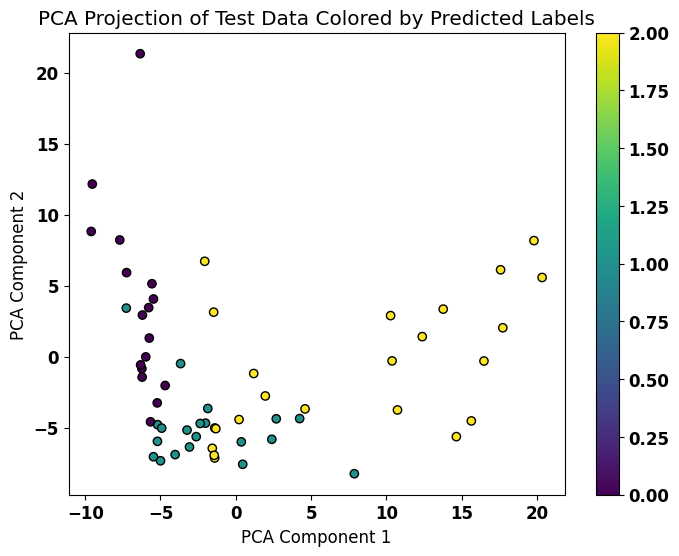

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.76      0.76        17
           1       0.45      0.43      0.44        21
           2       0.57      0.59      0.58        22

    accuracy                           0.58        60
   macro avg       0.59      0.59      0.59        60
weighted avg       0.58      0.58      0.58        60

Confusion Matrix:
 [[13  3  1]
 [ 3  9  9]
 [ 1  8 13]]


In [43]:
best_vector_name, best_clf = get_best_vector_clf(rfc_result)
vis_classification(vector_type=best_vector_name, estimator=best_clf)


### Dimensionality Reduction

In [44]:
df_temp = rfc_result[rfc_result['Metric'] =='f1_macro']
# df_temp['Calibrated Estimator']
vector_rfc = df_temp[['Vector','Calibrated Estimator']].set_index('Vector').to_dict()['Calibrated Estimator']
vector_rfc

{'unigram': RandomForestClassifier(max_depth=38, random_state=8888),
 'unigram_bigram': RandomForestClassifier(max_depth=38, random_state=8888),
 'bigram': RandomForestClassifier(max_depth=39, random_state=8888),
 'bigram_trigram': RandomForestClassifier(max_depth=39, random_state=8888),
 'trigram': RandomForestClassifier(max_depth=39, random_state=8888)}

In [45]:
supported_columns_dict = {}
for df_name, df in dataframes.items():
    X_train, X_test, y_train, y_test = train_test_split(dataframes[df_name], df_target, test_size=0.2, random_state=random_state_number)

    selector = SelectFromModel(estimator=vector_rfc[df_name]).fit(X_train, y_train)

    filter_columns = selector.get_support()
    dataframes[df_name] = dataframes[df_name][:, filter_columns]

shape_dim = [] ; df_names = []
for df_name, df in dataframes.items():
    shape_dim.append(df.shape)
    df_names.append(df_name)
n_gram_df_dim = pd.DataFrame({'N-Gram Feature Vector':df_names, 'Data Dimension':shape_dim})
n_gram_df_dim

,N-Gram Feature Vector,Data Dimension
0,unigram,"(298, 1065)"
1,unigram_bigram,"(298, 3122)"
2,bigram,"(298, 3593)"
3,bigram_trigram,"(298, 4011)"
4,trigram,"(298, 3789)"


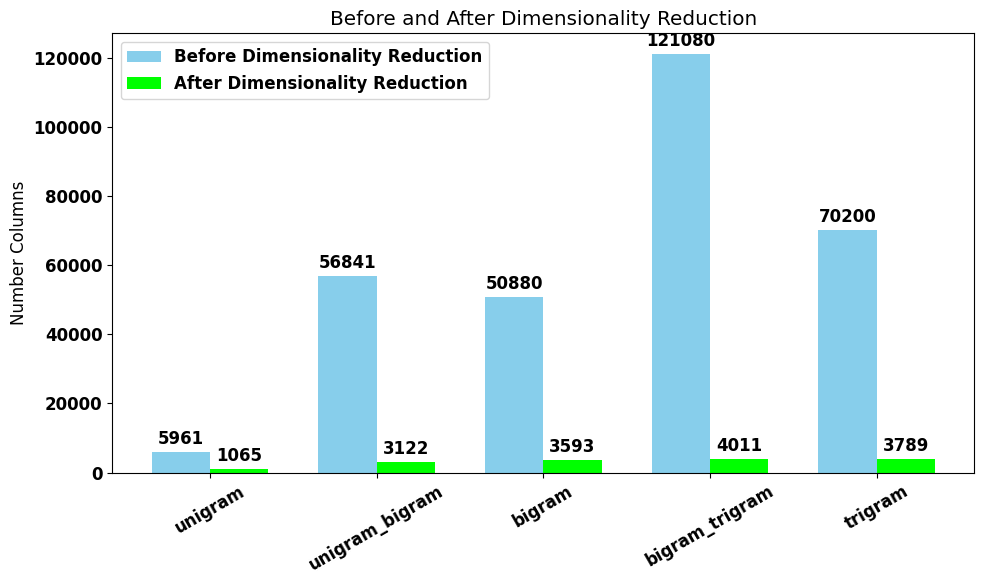

In [46]:
labels = n_gram_df_dim['N-Gram Feature Vector'].values
b4 = [shape[1] for shape in n_gram_df['Data Dimension'].values]
af = [shape[1] for shape in n_gram_df_dim['Data Dimension'].values]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, b4, width, label='Before Dimensionality Reduction', color='skyblue')
rects2 = ax.bar(x + width/2, af, width, label='After Dimensionality Reduction', color='lime')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number Columns')
ax.set_title('Before and After Dimensionality Reduction')
ax.set_xticks(x, labels)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [47]:
param_grid = {'n_neighbors': [5,7,9,11,13,15,17,19,21]}
base_estimator = KNeighborsClassifier()
knn_result = get_performance(param_grid, base_estimator, dataframes)
knn_result

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

,Vector,Metric,Calibrated Estimator,Best CV Metric Score,Test Predict Metric Score
0,unigram,f1_macro,KNeighborsClassifier(n_neighbors=7),0.647133,0.884215
1,unigram,precision_macro,KNeighborsClassifier(n_neighbors=7),0.814098,0.893436
2,unigram,recall_macro,KNeighborsClassifier(n_neighbors=7),0.654365,0.888889
3,unigram_bigram,f1_macro,KNeighborsClassifier(),0.552317,0.872167
4,unigram_bigram,precision_macro,KNeighborsClassifier(n_neighbors=11),0.768699,0.833333
5,unigram_bigram,recall_macro,KNeighborsClassifier(),0.579762,0.879630
6,bigram,f1_macro,KNeighborsClassifier(n_neighbors=17),0.182196,0.224561
7,bigram,precision_macro,KNeighborsClassifier(n_neighbors=17),0.180259,0.436782
8,bigram,recall_macro,KNeighborsClassifier(n_neighbors=17),0.340741,0.370370
9,bigram_trigram,f1_macro,KNeighborsClassifier(n_neighbors=17),0.182196,0.224561


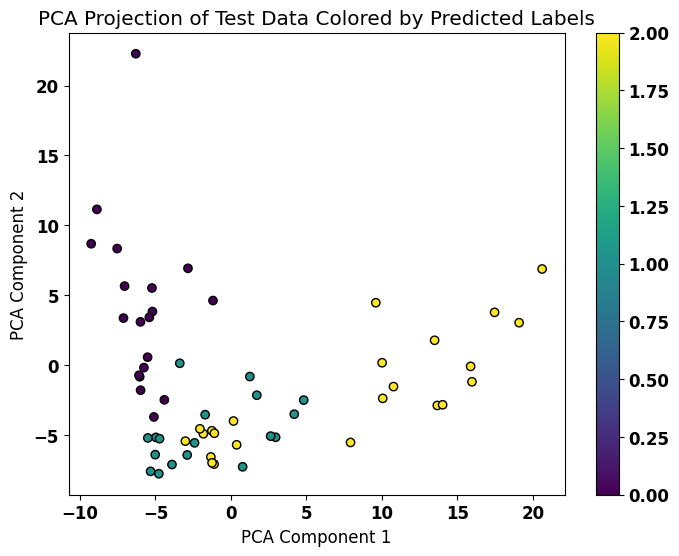

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.88      0.83        17
           1       0.56      0.48      0.51        21
           2       0.65      0.68      0.67        22

    accuracy                           0.67        60
   macro avg       0.67      0.68      0.67        60
weighted avg       0.66      0.67      0.66        60

Confusion Matrix:
 [[15  2  0]
 [ 3 10  8]
 [ 1  6 15]]


In [48]:
best_vector, best_clf =  get_best_vector_clf(knn_result)
vis_classification(vector_type = best_vector, estimator = best_clf)

In [49]:
param_grid = {'max_depth': [None,4,6,7,8,30,32,35],'min_samples_split': [2,3,4,5,35,10,16,20]}
base_estimator = DecisionTreeClassifier(random_state=random_state_number)
dtc_result = get_performance(param_grid, base_estimator, dataframes)
dtc_result

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

,Vector,Metric,Calibrated Estimator,Best CV Metric Score,Test Predict Metric Score
0,unigram,f1_macro,"DecisionTreeClassifier(max_depth=8, min_samples_split=5, random_state=8888)",0.864409,0.840555
1,unigram,precision_macro,"DecisionTreeClassifier(max_depth=8, min_samples_split=5, random_state=8888)",0.873810,0.850932
2,unigram,recall_macro,"DecisionTreeClassifier(max_depth=8, min_samples_split=5, random_state=8888)",0.865608,0.842593
3,unigram_bigram,f1_macro,"DecisionTreeClassifier(max_depth=32, min_samples_split=5, random_state=8888)",0.859413,0.887319
4,unigram_bigram,precision_macro,"DecisionTreeClassifier(max_depth=4, random_state=8888)",0.873860,0.863636
5,unigram_bigram,recall_macro,"DecisionTreeClassifier(max_depth=32, min_samples_split=5, random_state=8888)",0.858466,0.893519
6,bigram,f1_macro,"DecisionTreeClassifier(max_depth=8, min_samples_split=10, random_state=8888)",0.683932,0.853301
7,bigram,precision_macro,"DecisionTreeClassifier(max_depth=7, min_samples_split=10, random_state=8888)",0.806031,0.838235
8,bigram,recall_macro,"DecisionTreeClassifier(min_samples_split=16, random_state=8888)",0.705291,0.865741
9,bigram_trigram,f1_macro,"DecisionTreeClassifier(max_depth=30, random_state=8888)",0.719543,0.851780


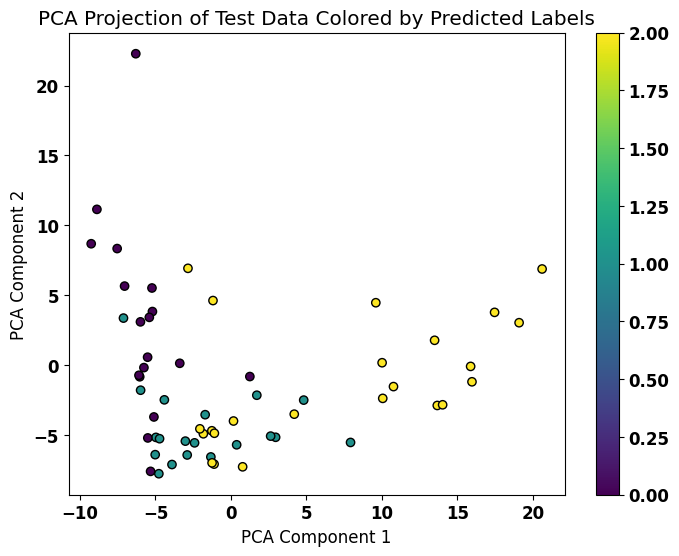

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.71      0.69        17
           1       0.47      0.43      0.45        21
           2       0.61      0.64      0.62        22

    accuracy                           0.58        60
   macro avg       0.58      0.59      0.59        60
weighted avg       0.58      0.58      0.58        60

Confusion Matrix:
 [[12  4  1]
 [ 4  9  8]
 [ 2  6 14]]


In [50]:
best_vector, best_clf =  get_best_vector_clf(dtc_result)
vis_classification(vector_type = best_vector, estimator = best_clf)

In [58]:
# df_result = pd.concat([knn_result,
#                       dtc_result,
#                       rfc_result
#                       ]
#                      ).reset_index(drop=True)

# df_result.groupby(['Metric']).max()

In [52]:
# Combine results
df_result = pd.concat([knn_result, dtc_result, rfc_result]).reset_index(drop=True)

# For each metric, get the row with the highest CV score
best_per_metric = df_result.loc[
    df_result.groupby("Metric")["Best CV Metric Score"].idxmax()
].reset_index(drop=True)

# View the best model per metric
best_per_metric


,Vector,Metric,Calibrated Estimator,Best CV Metric Score,Test Predict Metric Score
0,unigram,f1_macro,"DecisionTreeClassifier(max_depth=8, min_samples_split=5, random_state=8888)",0.864409,0.840555
1,unigram_bigram,precision_macro,"DecisionTreeClassifier(max_depth=4, random_state=8888)",0.873860,0.863636
2,unigram,recall_macro,"DecisionTreeClassifier(max_depth=8, min_samples_split=5, random_state=8888)",0.865608,0.842593


### Obtain Best Classifier and Feature Vector

In [53]:
def get_best_result(df_result, metric_score):
    df_result_t = df_result[df_result.Metric== 'precision_macro']
    precision_macro_df = df_result_t.loc[df_result_t[metric_score].idxmax()].to_frame().T

    df_result_t = df_result[df_result.Metric== 'recall_macro']
    recall_macro_df = df_result_t.loc[df_result_t[metric_score].idxmax()].to_frame().T

    df_result_t = df_result[df_result.Metric== 'f1_macro']
    f1_macro_df = df_result_t.loc[df_result_t[metric_score].idxmax()].to_frame().T

    return pd.concat([precision_macro_df,recall_macro_df,f1_macro_df])

In [54]:
best_cv_result = get_best_result(df_result, 'Best CV Metric Score')
display(best_cv_result)
temp = best_cv_result[best_cv_result['Metric'] == 'f1_macro']
best_clf = temp['Calibrated Estimator'].values[0]
best_vector = temp['Vector'].values[0]

,Vector,Metric,Calibrated Estimator,Best CV Metric Score,Test Predict Metric Score
19,unigram_bigram,precision_macro,"DecisionTreeClassifier(max_depth=4, random_state=8888)",0.87386,0.863636
17,unigram,recall_macro,"DecisionTreeClassifier(max_depth=8, min_samples_split=5, random_state=8888)",0.865608,0.842593
15,unigram,f1_macro,"DecisionTreeClassifier(max_depth=8, min_samples_split=5, random_state=8888)",0.864409,0.840555


In [55]:
get_best_result(df_result, 'Test Predict Metric Score')

,Vector,Metric,Calibrated Estimator,Best CV Metric Score,Test Predict Metric Score
31,unigram,precision_macro,"(DecisionTreeClassifier(max_depth=38, max_features='sqrt',\n random_state=1985925507), DecisionTreeClassifier(max_depth=38, max_features='sqrt',\n random_state=1459224502), DecisionTreeClassifier(max_depth=3...",0.865998,0.952381
32,unigram,recall_macro,"(DecisionTreeClassifier(max_depth=38, max_features='sqrt',\n random_state=1985925507), DecisionTreeClassifier(max_depth=38, max_features='sqrt',\n random_state=1459224502), DecisionTreeClassifier(max_depth=3...",0.825529,0.953704
30,unigram,f1_macro,"(DecisionTreeClassifier(max_depth=38, max_features='sqrt',\n random_state=1985925507), DecisionTreeClassifier(max_depth=38, max_features='sqrt',\n random_state=1459224502), DecisionTreeClassifier(max_depth=3...",0.816968,0.950342


### Evaluate on Each Class Labels

In [56]:
X_train, X_test, y_train, y_test = train_test_split(dataframes[best_vector], df_target, test_size=0.2, \
                                                    random_state=random_state_number)
clf = best_clf.fit(X_train, y_train)
y_test_pred= clf.predict(X_test)
target_names = ['Discharge Summary', 'ENT', 'Neurosurgery']
print(classification_report(y_test,y_test_pred,target_names=target_names))

                   precision    recall  f1-score   support

Discharge Summary       1.00      0.89      0.94        18
              ENT       0.86      0.75      0.80        24
     Neurosurgery       0.70      0.89      0.78        18

         accuracy                           0.83        60
        macro avg       0.85      0.84      0.84        60
     weighted avg       0.85      0.83      0.84        60



In [57]:
sample_predict = pd.DataFrame({'Actual Y Test': le.inverse_transform(y_test),'Best Prediction':le.inverse_transform(y_test_pred)})
sample_predict.head(20)

,Actual Y Test,Best Prediction
0,ENT - Otolaryngology,ENT - Otolaryngology
1,ENT - Otolaryngology,ENT - Otolaryngology
2,ENT - Otolaryngology,ENT - Otolaryngology
3,ENT - Otolaryngology,Neurosurgery
4,Neurosurgery,Neurosurgery
5,Neurosurgery,Neurosurgery
6,ENT - Otolaryngology,ENT - Otolaryngology
7,Discharge Summary,Discharge Summary
8,Neurosurgery,Neurosurgery
9,ENT - Otolaryngology,ENT - Otolaryngology
